In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for density plots
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('first_try_normalized.keras')

# Load the data from the SQLite database
conn = sqlite3.connect('../../../../data/nfp2/nfp2.db')  # Adjust the path to your database file
query = "SELECT * FROM stellarators"  # Adjust your query as needed
data_df = pd.read_sql_query(query, conn)
conn.close()

# Clean the data
data_df_clean = data_df[data_df['convergence'] == 1]
data_df_clean = data_df_clean.dropna(subset=['quasisymmetry'])

# Define features (X) and target (Y)
X = data_df_clean[['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1', 'zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']]
Y = np.log(data_df_clean['quasisymmetry'])

# Normalize the features and target
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y.values.reshape(-1, 1)).flatten()

# Split the data into training and testing sets
features_no_outliers, test_features_no_outliers, target_no_outliers, test_target_no_outliers = train_test_split(
    X_scaled, Y_scaled, test_size=0.2, random_state=42)

2024-07-22 14:08:41.730420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 14:08:41.747008: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 14:08:41.751854: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 14:08:41.766388: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 14:08:42.598188: W tensorflow/compiler/tf2

   1/1491 ━━━━━━━━━━━━━━━━━━━━ 1:44 70ms/step

1491/1491 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step
Mean Squared Error: 0.012915572346035452
R^2 Score: 0.9868806542611006


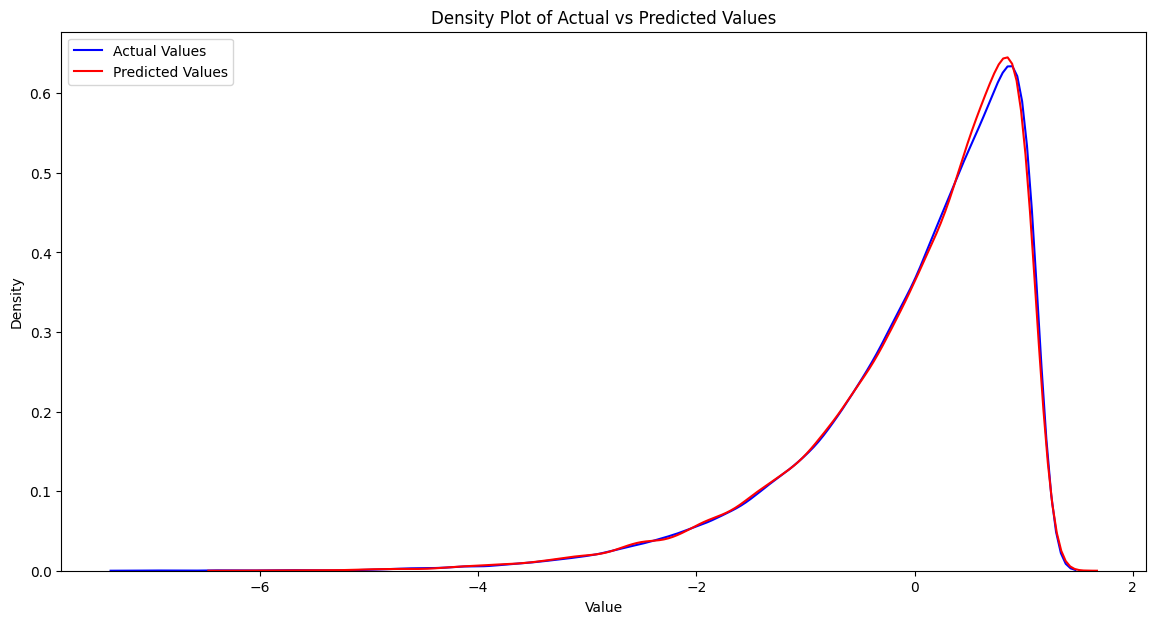

In [2]:
# Make predictions on the test set
predictions = model.predict(test_features_no_outliers).flatten()

# Evaluate the model
mse = mean_squared_error(test_target_no_outliers, predictions)
r2 = r2_score(test_target_no_outliers, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot density plots for predicted and actual values
plt.figure(figsize=(14, 7))

# Plot density for actual values
sns.kdeplot(test_target_no_outliers, label='Actual Values', color='blue', fill=False)

# Plot density for predicted values
sns.kdeplot(predictions, label='Predicted Values', color='red', fill=False)

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot of Actual vs Predicted Values')
plt.legend()
plt.show()

In [6]:
import shap
import numpy as np

# Define a function to get a smaller random sample from the dataset
def get_background_data(X, sample_size=100):
    np.random.seed(42)
    sample_indices = np.random.choice(X.index, size=min(sample_size, len(X)), replace=False)
    return X.loc[sample_indices]

# Create a background dataset by sampling a subset of the original data
background = get_background_data(features_no_outliers, sample_size=10)

# Define the prediction function
def predict_fn(X):
    return model.predict(X).flatten()

# Create the SHAP explainer with the smaller background dataset
explainer = shap.KernelExplainer(predict_fn, background)

# Compute SHAP values for a subset of the test set to reduce computation time
shap_values = explainer.shap_values(test_features_no_outliers.head(100))

# Plot SHAP values
shap.initjs()
shap.summary_plot(shap_values, test_features_no_outliers.head(100))


AttributeError: 'numpy.ndarray' object has no attribute 'index'